# Explainable AI (XAI)

## 04_LIME

##### Descrição
Sabemos que os modelos de Inteligência Artificial apresentam uma natureza do tipo caixa-preta (black-box).

É necessário compreender como as redes desenvolvidas realizam suas predições.

Existem alguns métodos de interpretabilidade que tentam explicar o processo de decisão dos modelos de AI.
Veremos alguns destes nos próximos Notebooks...




## Classificação de Imagens
Usaremos alguns métodos de XAI no modelo VGG16, que é uma rede convolucional amplamente conhecida e utilizada.

###### Os primeiros passos são iguais aos anteriores. O que altera é a função para gerar o LIME

#### Carregando Bibliotecas

In [1]:
from matplotlib import pyplot as plt
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow.keras.applications.vgg16 import VGG16 as Model
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.applications.vgg16 import preprocess_input
import os
import sys

In [2]:
print('...')
print('--> VERSOES')
print("Versao python:",sys.version)
print("Versao de tensorflow:",tf.__version__)
print("Versao de Numpy:", np.__version__)

...
--> VERSOES
Versao python: 3.9.7 (default, Sep 16 2021, 16:59:28) [MSC v.1916 64 bit (AMD64)]
Versao de tensorflow: 2.8.0
Versao de Numpy: 1.20.3


#### Carregando Modelo

In [3]:
model = Model(weights='imagenet', include_top=True)
model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

#### Carregando Imagem
Usaremos uma imagem baixada da internet, de uma das classes existentes no ImageNet.

Observe que o modelo VGG16 recebe como entrada uma imagem de tamanho 224x224x3.

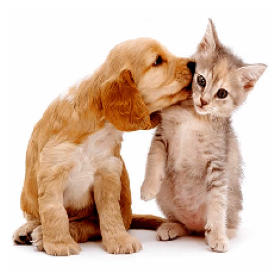

In [4]:
# Carregar imagem
original_img = load_img('../Images/catdog.jpg', target_size=(224, 224))

# Converter para um Numpy Array
image = np.asarray(np.array(original_img))

# Realiza o preprocessamento da imagem para ser utilizada na VGG16
X = preprocess_input(image)

# Plotar imagem de entrada
plt.imshow(image)
plt.axis('off')
plt.tight_layout()
plt.show()

In [5]:
print('Image X shape:\n', X.shape, type(X))

Image X shape:
 (224, 224, 3) <class 'numpy.ndarray'>


#### Classificando imagem X

In [6]:
from keras.applications.imagenet_utils import decode_predictions

# Entrada do VGG16 é do tipo (None, 224, 224, 3). Então temos que expandir a dimensão da nossa entrada.
x_img = np.expand_dims(X, axis=0)

# Classificar a imagem x
preds = model.predict(x_img)

# Apresenta as 5 top predições 
print('Top5 Predições do modelo:')
for x in decode_predictions(preds)[0]:
    print(x)

Top5 Predições do modelo:
('n02099601', 'golden_retriever', 0.20480192)
('n02102318', 'cocker_spaniel', 0.1354943)
('n03223299', 'doormat', 0.06035429)
('n02124075', 'Egyptian_cat', 0.05699708)
('n02808304', 'bath_towel', 0.055041)


## LOCAL INTERPRETABLE MODEL-AGNOSTIC EXPLANATIONS (LIME)
Usa uma estratégia de perturbação e modelo linear esparço para identificar quais características são mais importantes. No contexto de Imagens, caractertísticas são SUPERPIXELS, que são segmentos inteiros de uma imagem, podendo ou não ser "apagados". Estes segmentos são calculados algoritmamente.

Uma vantagem do LIME é que ele deriva coeficientes lineares que podem dizer quais características são positiva ou negativamente correlacionadas com a classe predita.

Intuitivamente, uma explicação é uma aproximação linear local do comportamento do modelo. Enquanto o modelo pode ser muito complexo globalmente, é fácil realizar uma aproximação ao redor da vizinhança de uma instancia em particular. Enquanto tratamos o modelo como uma caixa preta, nós perturbamos a instancia que queremos explicar e aprendemos um modelo linear esparço ao redor disso, como uma explicação.

#### Importando bibliotecas para gerar o LIME

In [16]:
import lime
from lime import lime_image
# Lime version used in this notebook: 0.2.0.1
import skimage.segmentation

In [41]:
# Criando uma explicação
explainer = lime_image.LimeImageExplainer()

# arg hide_color é a cor do superpixel tornado em OFF.
# Se hide_color = NONE, o superpixel será substituido pela média dos seus pixels
explanation = explainer.explain_instance(image.astype('double'),\
                                         model.predict, top_labels=5,\
                                         hide_color=0, num_samples=250)


  0%|          | 0/250 [00:00<?, ?it/s]

### Aplicando LIME
Após gerar a explicação do LIME vamos ver quais são os superpixels que correspondem à explicação da primeira classe predita:

- golden_retriever

num_features define que serão mostrados os 5 superpixels que são mais positivos para a classe predita.

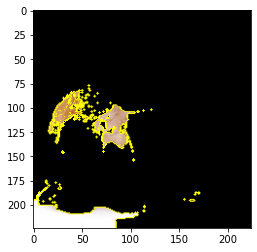

In [46]:
from skimage.segmentation import mark_boundaries

temp1, mask1 = explanation.get_image_and_mask(explanation.top_labels[0],\
                                            positive_only=True,\
                                            num_features=5,\
                                            hide_rest=True)

plt.imshow(mark_boundaries(temp1.astype(np.uint8), mask1))

Acima são apresentados os superpixels correspondentes a explicação da classe.

Agora sobrepomos os superpixels na imagem original para visualizar as regiões que eles correspondem.

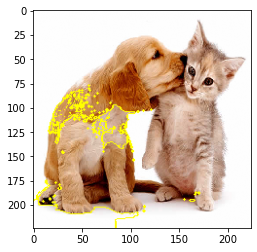

In [45]:
temp2 , mask2 = explanation.get_image_and_mask(explanation.top_labels[0],\
                                            positive_only=True,\
                                            num_features=5,\
                                            hide_rest=False)
plt.imshow(mark_boundaries(temp2.astype(np.uint8), mask2))

Podemos ver também quais regiões correspondem a favor (coeficientes positivos) e contra (coeficientes negativos) a classe predita.

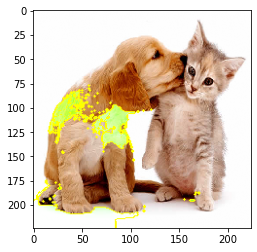

In [52]:
temp3, mask3 = explanation.get_image_and_mask(explanation.top_labels[0],\
                                            positive_only=False,\
                                            num_features=5,\
                                            hide_rest=False)

plt.imshow(mark_boundaries(temp3.astype(np.uint8), mask3))

Alternativamente, nós podemos plotar os pesos das explicações na forma de heatmaps.
As cores apresentam os valores dos pesos.

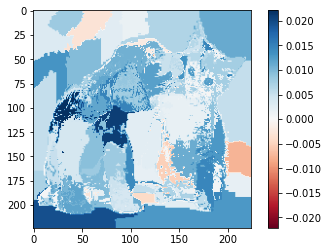

In [53]:
#Select the same class explained on the figures above.
ind =  explanation.top_labels[0]

#Map each explanation weight to the corresponding superpixel
dict_heatmap = dict(explanation.local_exp[ind])
heatmap = np.vectorize(dict_heatmap.get)(explanation.segments) 

#Plot. The visualization makes more sense if a symmetrical colorbar is used.
plt.imshow(heatmap, cmap = 'RdBu', vmin  = -heatmap.max(), vmax = heatmap.max())
plt.colorbar()

### Aplicando LIME
Após gerar a explicação do LIME vamos ver quais são os superpixels que correspondem à explicação da quarta classe predita:

- Egyptian_cat

num_features define que serão mostrados os 5 superpixels que são mais positivos para a classe predita.

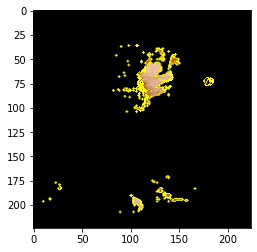

In [55]:
from skimage.segmentation import mark_boundaries

temp1, mask1 = explanation.get_image_and_mask(explanation.top_labels[3],\
                                            positive_only=True,\
                                            num_features=10,\
                                            hide_rest=True)

plt.imshow(mark_boundaries(temp1.astype(np.uint8), mask1))

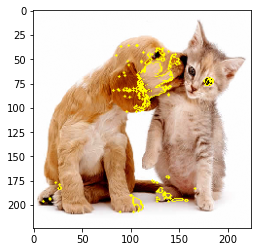

In [57]:
temp2 , mask2 = explanation.get_image_and_mask(explanation.top_labels[3],\
                                            positive_only=True,\
                                            num_features=10,\
                                            hide_rest=False)
plt.imshow(mark_boundaries(temp2.astype(np.uint8), mask2))

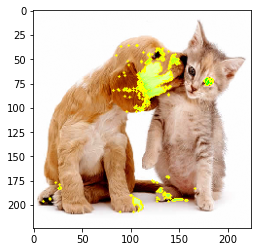

In [59]:
temp3, mask3 = explanation.get_image_and_mask(explanation.top_labels[3],\
                                            positive_only=False,\
                                            num_features=10,\
                                            hide_rest=False)

plt.imshow(mark_boundaries(temp3.astype(np.uint8), mask3))

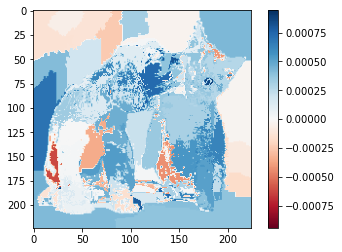

In [60]:
#Select the same class explained on the figures above.
ind =  explanation.top_labels[3]

#Map each explanation weight to the corresponding superpixel
dict_heatmap = dict(explanation.local_exp[ind])
heatmap = np.vectorize(dict_heatmap.get)(explanation.segments) 

#Plot. The visualization makes more sense if a symmetrical colorbar is used.
plt.imshow(heatmap, cmap = 'RdBu', vmin  = -heatmap.max(), vmax = heatmap.max())
plt.colorbar()